In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('DelayData.csv')

In [3]:
data = data[(data['arrdelay'] >= 0) | (data['depdelay'] >= 0)]

In [4]:
print(data['arrdelay'].describe())
print(data['depdelay'].describe())

count    688105.000000
mean         18.912323
std          44.205521
min         -83.000000
25%          -1.000000
50%           6.000000
75%          23.000000
max        1452.000000
Name: arrdelay, dtype: float64
count    690095.000000
mean         19.891108
std          42.935352
min        -866.000000
25%           0.000000
50%           5.000000
75%          22.000000
max        1476.000000
Name: depdelay, dtype: float64


In [5]:
# Nan

for col in data.columns:
    print(col)
    print(data[col].isna().value_counts(), end='\n\n')

depdelay
False    690095
Name: depdelay, dtype: int64

arrdelay
False    688105
True       1990
Name: arrdelay, dtype: int64

scheduleddepartdatetime
False    690095
Name: scheduleddepartdatetime, dtype: int64

origin
False    690095
Name: origin, dtype: int64

dest
False    690095
Name: dest, dtype: int64

uniquecarrier
False    690095
Name: uniquecarrier, dtype: int64

marketshareorigin
False    690095
Name: marketshareorigin, dtype: int64

marketsharedest
False    690095
Name: marketsharedest, dtype: int64

hhiorigin
False    690095
Name: hhiorigin, dtype: int64

hhidest
False    690095
Name: hhidest, dtype: int64

nonhubairportorigin
False    690095
Name: nonhubairportorigin, dtype: int64

smallhubairportorigin
False    690095
Name: smallhubairportorigin, dtype: int64

mediumhubairportorigin
False    690095
Name: mediumhubairportorigin, dtype: int64

largehubairportorigin
False    690095
Name: largehubairportorigin, dtype: int64

nonhubairportdest
False    690095
Name: nonhubairpor

There are not many Nans in data so lets just drop these samples.

In [6]:
data.dropna(how='any', inplace=True)

Lets look at the target variable distribution.

<Axes: xlabel='arrdelay', ylabel='Count'>

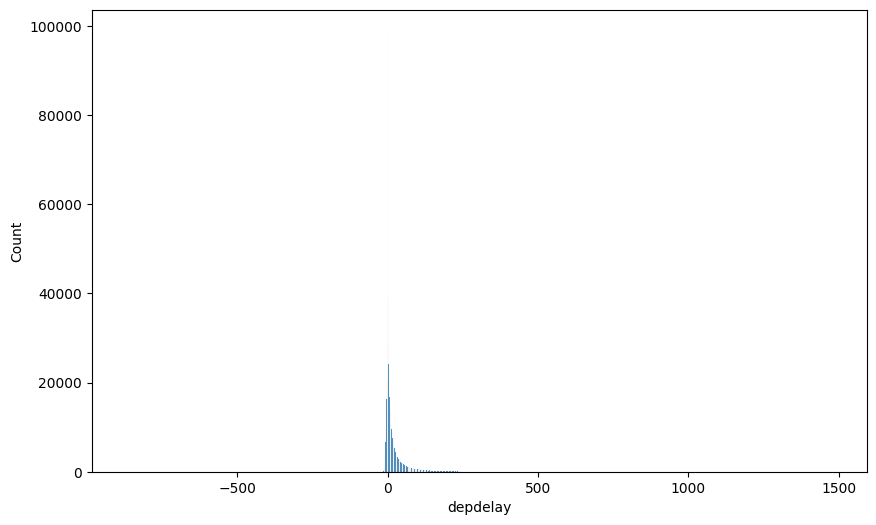

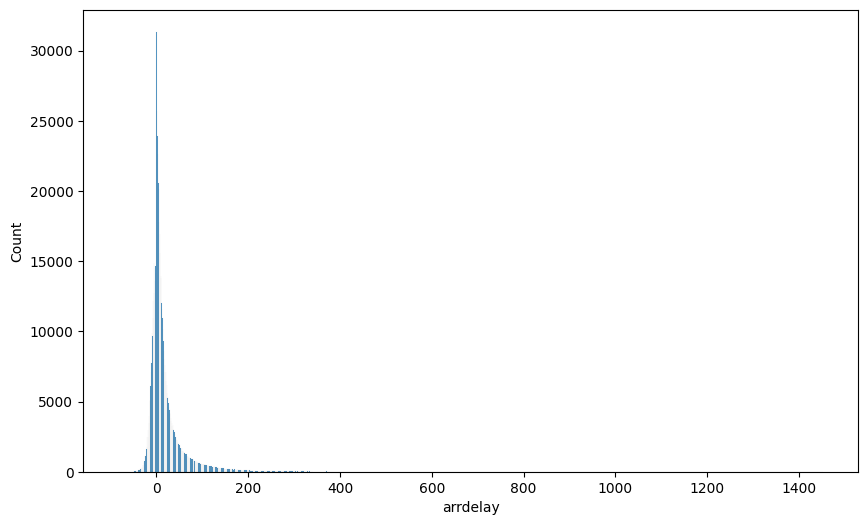

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(data['depdelay'])

plt.figure(figsize=(10, 6))
sns.histplot(data['arrdelay'])

We can see some strong outliers. Lets just delete them.

In [8]:
data = data[(data['depdelay'] > -50) & (data['depdelay'] < 300)]
data = data[(data['arrdelay'] > -100) & (data['arrdelay'] < 300)]

In [9]:
print('Number of unique destinations:', len(data['dest'].unique()))
print('Number of unique destinations:', len(data['origin'].unique()))

Number of unique destinations: 325
Number of unique destinations: 258


In [10]:
data['route'] = data['origin'] + '-' + data['dest']
data['route'].head()

0    ELP-SAT
1    ATL-MSY
2    DFW-JFK
3    SEA-EWR
4    SLC-RNO
Name: route, dtype: object

In [11]:
print('Number of unique :', len(data['route'].unique()))

Number of unique : 5674


In [12]:
numeric_data = data.select_dtypes(['float64', 'int64'])
bin_features = []

for col in numeric_data.columns:
    if len(numeric_data[col].unique()) == 2:
        numeric_data.drop(col, axis=1, inplace=True)
        bin_features.append(col)

numeric_data.head()

,depdelay,arrdelay,marketshareorigin,marketsharedest,hhiorigin,hhidest,year,month,dayofmonth,dayofweek,...,numflights,distance,temperature,windspeed,windspeedsquare,windgustspeed,originmetropop,originmetrogdppercapita,destmetropop,destmetrogdppercapita
0,0,-4.0,0.618467,0.407567,0.417090,0.226878,2004,1,8,4,...,19.579,496,15.340000,10.300000,106.090000,0.0,702433,27314.633,1843927,35005.234
1,-4,11.0,0.500757,0.096321,0.319589,0.196657,2004,1,22,4,...,19.548,425,11.500000,13.666667,186.777778,0.0,4802300,49081.773,1314721,48848.234
2,3,12.0,0.060898,0.131962,0.296126,0.214357,2004,1,29,4,...,19.545,1391,12.218868,13.528302,183.014952,0.0,5689982,50588.563,18747431,57295.402
3,-3,24.0,0.040522,0.347744,0.234712,0.249377,2004,1,14,3,...,19.261,2401,9.000000,0.000000,0.000000,0.0,3163703,57755.547,18747431,57295.402
4,0,-8.0,0.506899,0.176493,0.341763,0.277364,2004,1,14,3,...,19.261,422,-11.466667,7.666667,58.777778,0.0,1030597,45043.602,385049,49079.727


Lets use isolation forest in order to find the outliers and drop them.

In [13]:
from sklearn.ensemble import IsolationForest

isolation = IsolationForest(contamination=0.02, n_estimators=200, random_state=42)

isolation.fit(numeric_data)

outliers = isolation.predict(numeric_data)

data = data[outliers == 1]

<Axes: xlabel='arrdelay', ylabel='Count'>

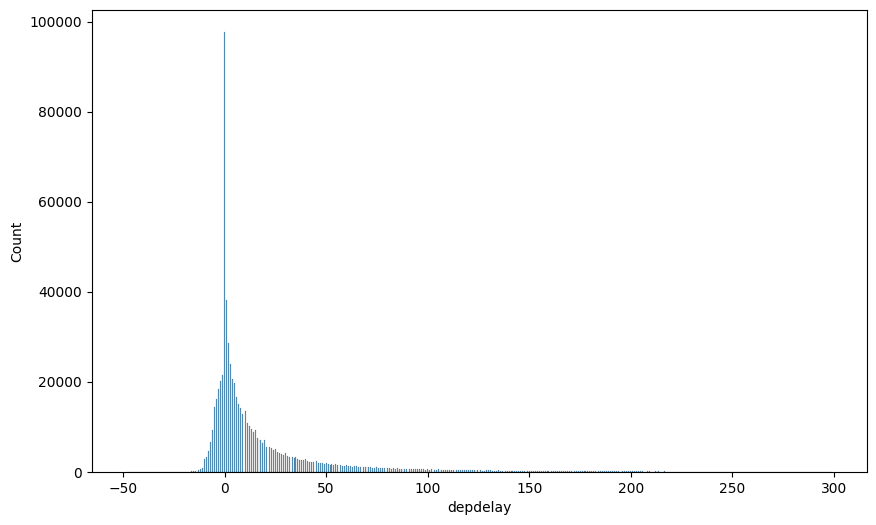

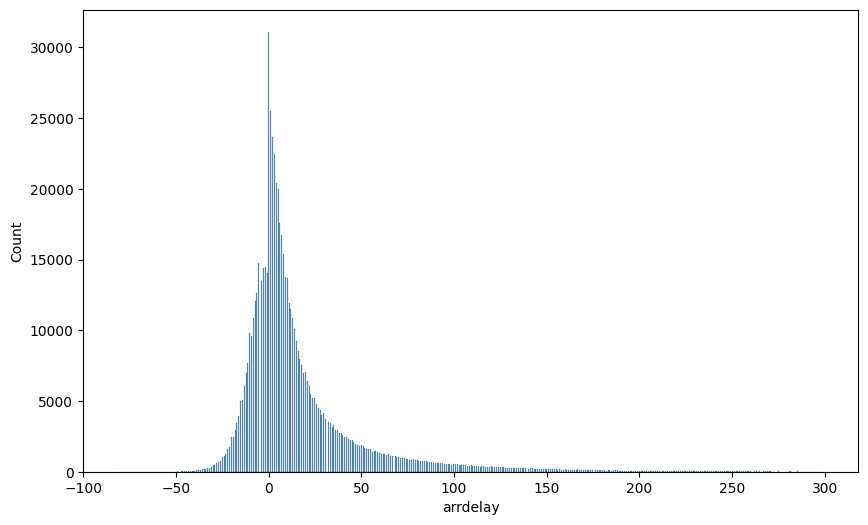

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(data['depdelay'])

plt.figure(figsize=(10, 6))
sns.histplot(data['arrdelay'])

<Axes: >

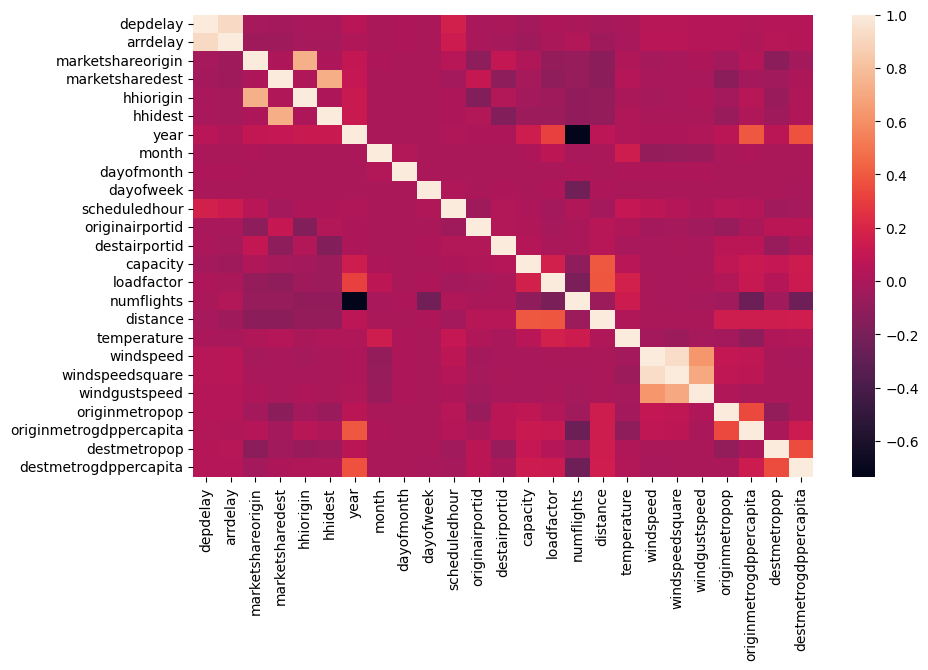

In [15]:
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr())

Windgustspeed and windspeedsquare are highly correlated with windspeed so lets drop it. Year is also useless.

In [16]:
data.drop(['windgustspeed', 'windspeedsquare', 'year'], axis=1, inplace=True)

Lets check the importance of the binary categorical features by using Mann and Whitney test because features dont have normal distribution.

In [17]:
from scipy import stats

useful_cat = []
useless_cat = []

for col in bin_features:
    group1 = data[data[col] == 1]['depdelay']
    group2 = data[data[col] == 0]['depdelay']
    statistic, p_value = stats.mannwhitneyu(group1, group2)
    print(p_value)

    if p_value >= 0.05:
        print(f'{col} dont affect the depdelay')
    else:
        print(f'{col} affects the depdelay')
        useful_cat.append(col)
    
    group1 = data[data[col] == 1]['arrdelay']
    group2 = data[data[col] == 0]['arrdelay']

    if p_value >= 0.05:
        print(f'{col} dont affect the arrdelay')

        if useful_cat[-1] != col:
            useless_cat.append(col)
    else:
        print(f'{col} affects the arrdelay')

        if useful_cat[-1] != col:
            useful_cat.append(col)
    print()

4.518322708037807e-228
nonhubairportorigin affects the depdelay
nonhubairportorigin affects the arrdelay

2.2674012988282456e-32
smallhubairportorigin affects the depdelay
smallhubairportorigin affects the arrdelay

2.543233376724156e-19
mediumhubairportorigin affects the depdelay
mediumhubairportorigin affects the arrdelay

4.6976222062387116e-158
largehubairportorigin affects the depdelay
largehubairportorigin affects the arrdelay

1.291004147408379e-65
nonhubairportdest affects the depdelay
nonhubairportdest affects the arrdelay

1.6995915384082304e-29
smallhubairportdest affects the depdelay
smallhubairportdest affects the arrdelay

0.1451974583532437
mediumhubairportdest dont affect the depdelay
mediumhubairportdest dont affect the arrdelay

2.123200667039615e-132
largehubairportdest affects the depdelay
largehubairportdest affects the arrdelay

0.0
nonhubairlineorigin affects the depdelay
nonhubairlineorigin affects the arrdelay

3.000407001350501e-166
smallhubairlineorigin affec

In [18]:
data.drop(useless_cat, axis=1, inplace=True)
data.drop(['destairportid', 'scheduleddepartdatetime'], axis=1, inplace=True)

Lets do the Kruskal test as we know that we can't apply anova analysis here. Then we will apply Dann test to see what exact feature should be used.

In [20]:
import scikit_posthocs as sp

cats = ['uniquecarrier', 'originstate']

for col in cats:
    unique = data[col].unique()
    groups = [data[data[col] == un]['depdelay'] for un in unique]
    
    statistic, p_value = stats.kruskal(*groups)

    alpha = 0.05
    print(col)
    print(p_value)
    if p_value < alpha:
        print("Reject the null hypothesis.")
        dunn_result = sp.posthoc_dunn(groups, p_adjust='bonferroni')

        print("Dunn test results:")
        print(dunn_result)
    else:
        print("Do not reject the null hypothesis.")
    print()



uniquecarrier
0.0
Reject the null hypothesis.
Dunn test results:
               1              2              3              4              5   \
1    1.000000e+00   0.000000e+00  2.502604e-194   0.000000e+00  7.020205e-135   
2    0.000000e+00   1.000000e+00   1.000000e+00   1.000000e+00   1.763666e-30   
3   2.502604e-194   1.000000e+00   1.000000e+00   1.000000e+00   1.092468e-24   
4    0.000000e+00   1.000000e+00   1.000000e+00   1.000000e+00   9.813446e-27   
5   7.020205e-135   1.763666e-30   1.092468e-24   9.813446e-27   1.000000e+00   
6   1.320867e-181   9.897546e-49   1.651565e-39   1.766081e-43   1.000000e+00   
7    1.031234e-17   0.000000e+00  7.870529e-210   0.000000e+00  1.164506e-158   
8    4.843545e-10   0.000000e+00  1.348675e-194   0.000000e+00  2.161963e-150   
9   9.939033e-255   1.000000e+00   1.000000e+00   1.000000e+00   2.032595e-22   
10   7.585966e-90   9.143797e-07   5.115178e-06   1.047008e-09   7.029400e-41   
11   1.000000e+00  1.870683e-192  1.257430e-

In [21]:
data = pd.get_dummies(data, columns=['originstate', 'uniquecarrier'], drop_first=True)

Taqi, I have done the basic preproccessing but I dont know what to do with the following feauters: route, origincity, tailnum, origin, dest. The last two I combined into route. So, I think we should drop them. Anyway, It's up to you. 